In [1]:
import requests
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

import logging
from linkedin_jobs_scraper import LinkedinScraper
from linkedin_jobs_scraper.events import Events, EventData
from linkedin_jobs_scraper.query import Query, QueryOptions, QueryFilters
from linkedin_jobs_scraper.filters import RelevanceFilters, TypeFilters

# Data Science skills

[TODO] Write description

In [2]:
# Parameters
job = "Data Science"
locations = ["Austria"]
keywords = ("Python", "R", "SQL", "noSQL", "Excel", "PowerBI", "Power BI", "Tableau", "TensorFlow", "PyTorch", "Spark", "Hadoop", "AWS", "Azure")

In [3]:
# Change root logger level (default is WARN)
logging.basicConfig(level = logging.INFO)
job_postings = []

# Fired once for each successfully processed job
def on_data(data: EventData):
    job_postings.append(data.link)

scraper = LinkedinScraper(
    chrome_executable_path=None,
    chrome_options=None,
    headless=True,
    max_workers=1,
    slow_mo=3,    # Slow down the scraper to avoid 'Too many requests 429' errors (in seconds)
    page_load_timeout=20 
)

# Add event listeners
scraper.on(Events.DATA, on_data)

queries = [
    Query(
        query=job,
        options=QueryOptions(
            locations=locations,
            limit=500,
            filters=QueryFilters(
                relevance=RelevanceFilters.RECENT,
                type=[TypeFilters.FULL_TIME]              
            )
        )
    ),
]

scraper.run(queries)

INFO:li:scraper:('Using strategy AnonymousStrategy',)
INFO:li:scraper:('Starting new query', "Query(query=Data Science options=QueryOptions(limit=500 locations=['Austria'] filters=QueryFilters(relevance=RelevanceFilters.RECENT type=[<TypeFilters.FULL_TIME: 'F'>]) optimize=False apply_link=False))")
INFO:li:scraper:('Chrome debugger url', 'http://localhost:50746')
INFO:li:scraper:('[Data Science][Austria]', 'Opening https://www.linkedin.com/jobs/search?keywords=Data+Science&location=Austria&sortBy=DD&f_JT=F&start=0')
INFO:li:scraper:('[Data Science][Austria]', 'Trying first selectors set')
INFO:li:scraper:('[Data Science][Austria]', 'Trying second selectors set')
INFO:li:scraper:('[Data Science][Austria]', 'OK')
INFO:li:scraper:('[Data Science][Austria]', 'Starting pagination loop')
INFO:li:scraper:('[Data Science][Austria]', 'Found 25 jobs')
INFO:li:scraper:('[Data Science][Austria][1]', 'Processed')
INFO:li:scraper:('[Data Science][Austria][2]', 'Processed')
INFO:li:scraper:('[Data Sc

In [15]:
# Check in how many job descriptions the keywords occur
counts = {keyword: 0 for keyword in keywords}
n_postings = 0

for url in job_postings:
    response = requests.get(url) 
    soup = BeautifulSoup(response.text, "html.parser")
    job_description = soup.find_all("div", {"class": "description__text"})
    # Skip postings that have no job description
    if len(job_description) > 0:
        n_postings += 1
        text = job_description[0].get_text()
        for key in counts.keys():
            key_space = key.center(len(key) + 2)        # Search for seperated Search for keywords
            key_comma = key.ljust(len(key) + 1, ",")    # Search for keywords in an enumeration
            key_slash = key.ljust(len(key) + 1, "/")    # Search for keywords seperated by a slash
            count_key_space = text.lower().count(key_space.lower())
            count_key_comma = text.lower().count(key_comma.lower())
            count_key_slash = text.lower().count(key_slash.lower())
            if count_key_space > 0 or count_key_comma > 0 or count_key_slash > 0: 
                counts[key] += 1

# Combine "PowerBI" and "Power BI"
counts["PowerBI"] += counts["Power BI"]
del counts["Power BI"]

In [16]:
# Results
print("{} job postings searched:".format(n_postings))
print(counts)

218 job postings searched:
{'Python': 96, 'R': 142, 'SQL': 68, 'noSQL': 9, 'Excel': 21, 'PowerBI': 26, 'Tableau': 16, 'TensorFlow': 12, 'PyTorch': 8, 'Spark': 22, 'Hadoop': 12, 'AWS': 26, 'Azure': 21}


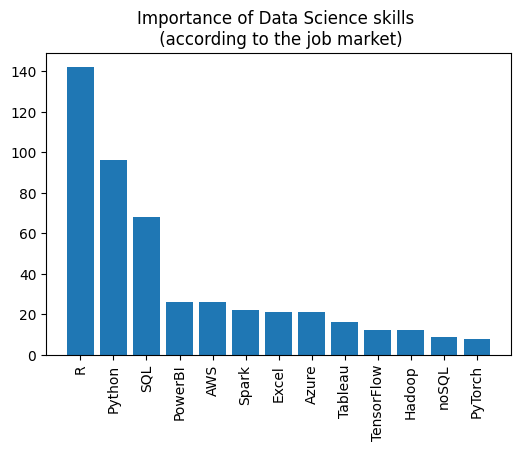

In [17]:
# Plot
sorted_counts = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))
fig, ax = plt.subplots()
fig.set_dpi(100)
ax.bar(sorted_counts.keys(), sorted_counts.values())
plt.title("Importance of Data Science skills \n (according to the job market)")
plt.xticks(rotation=90)
plt.show()